# Refinamento de Modelo CNN Pré-treinado

Este notebook foi desenvolvido para ser rodado em um ambiente Colab. Para testes de funcionalidade, sugerimos visitar [o notebook do Colab na pasta específica com as importações já feitas](https://drive.google.com/file/d/1qpPVi71bdkMrQP3Y-sWArya48-gcdZl0/view?usp=sharing).

O código foi feito para rodar em um Colab, mas utiliza o código escrito em [process.py](https://github.com/Inteli-College/2024-1B-T01-CC10-G01/blob/main/src/ProcessingPipeline/image_process/processes.py) e [pipeline.py](https://github.com/Inteli-College/2024-1B-T01-CC10-G01/blob/main/src/ProcessingPipeline/image_process/pipeline.py), ambos localizados no repositório do GitHub.

Para maior facilidade de importação, também estão disponíveis [nesta pasta do Google Drive](https://drive.google.com/drive/folders/1kwaFtcbv3C8RnB4BorXmu-2_XVH42i5L?usp=sharing).


## Importações e instalações

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import random
import cv2 as cv
import keras as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import data as tf_data
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2D, UpSampling2D


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Instalação necessária para importação dos módulos process.py e pipeline.py
!pip install PyQt5 --quiet
import PyQt5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.1/338.1 kB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 28.6 MB/s eta 0:00:00


In [ ]:
import sys
sys.path.append('/content/drive/Shareddrives/M10G01/notebooks') # Troque esse caminho para importação dos módulos process.py e pipeline.py

import test_import as TestImport
import pipeline as Pipeline
import processes as Processes

In [ ]:
TestImport.TestImportPrint()

Hello, Colab!


## Funções auxiliares

In [ ]:
from typing import Dict, Union, List
import numpy as np



def get_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray,
        n_categories: int) -> np.ndarray:
    '''
    Gets confusion matrix from predictions.

    Parameters:
    - y_true: true labels with shape (n_examples, ).
    - y_pred: predicted labels with shape (n_examples, ).
    - n_categories: the number of categories.

    Returns:
    n_categories x n_categories ndarray representing confusion matrix.
    '''
    assert y_true.shape == y_pred.shape
    assert y_true.ndim == 1

    mtx = np.zeros(shape=(n_categories, n_categories), dtype='uint64')

    for i in range(n_categories):
        category_i = (y_true == i)
        for j in range(n_categories):
            category_j = (y_pred == j)
            mtx[i, j] = (category_i & category_j).sum()

    return mtx


def get_binary_confusion_matrix(
        y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    '''
    Gets binary confusion matrix from hard predictions.

    Parameters:
    - y_true: Ground-truth with shape (n_examples, ).
      Assumes 1 is for positive and 0 for negative.
    - y_pred: Predictions with shape (n_examples, ).
      Assumes 1 is for positive and 0 for negative.

    Returns:
    2x2 binary confusion matrix (using index 0 for positive category).
    '''
    y_true = y_true.astype('uint8')
    y_pred = y_pred.astype('uint8')
    weights = np.ones(shape=y_true.shape, dtype='float32')

    tp = int(((y_true & y_pred)*weights).sum())
    tn = int((((y_true^1) & (y_pred^1))*weights).sum())
    fp = int((((y_true^1) & y_pred)*weights).sum())
    fn = int(((y_true & (y_pred^1))*weights).sum())

    return np.array([[tp, fn], [fp, tn]], dtype='uint64')


def extract_binary_confusion_matrix(
        conf_mtx: np.ndarray, category: int) -> np.ndarray:
    '''
    From (possibly) multi-class confusion matrix, and
    index of positive category, computes binary
    confusion matrix (using index 0 for positive category).

    Parameters:
    - conf_mtx: square ndarray representing the confusion matrix.
    - category: index of category to be considered positive category.

    Returns:
    2x2 binary confusion matrix (using index 0 for positive category).
    '''
    assert category < conf_mtx.shape[0]
    summ_col = conf_mtx[:, category].sum()
    summ_row = conf_mtx[category].sum()
    summ = conf_mtx.sum()
    tp = conf_mtx[category, category]
    tn = summ - (summ_col + summ_row - tp)
    fp = summ_col - tp
    fn = summ_row - tp
    return np.array([
        [tp, fn],
        [fp, tn]], dtype='uint64')


class ClassificationMetrics:
    '''
    Metrics for multi-class predictor classification.
    '''

    @classmethod
    def from_decisions(cls, y_true: np.ndarray, y_pred: np.ndarray,
            n_categories: int) -> 'ClassificationMetrics':
        '''
        Instantiates object from hard predictions.
        '''
        mtx = get_confusion_matrix(y_true, y_pred, n_categories=n_categories)
        return cls(mtx)

    @classmethod
    def from_confusion_matrix(cls, conf_mtx: np.ndarray) \
            -> 'ClassificationMetrics':
        '''
        Instantiates object from confusion matrix.
        '''
        return cls(np.array(conf_mtx))

    def __init__(self, conf_mtx: np.ndarray):
        self._conf_mtx = conf_mtx
        self._n_categories = conf_mtx.shape[0]

    @property
    def conf_mtx(self) -> np.ndarray:
        '''
        The confusion matrix of the evaluation.
        '''
        return self._conf_mtx

    @property
    def n_categories(self) -> int:
        '''
        The number of categories of the evaluated classifiers.
        '''
        return self._n_categories

    @property
    def accuracy(self) -> float:
        '''
        The accuracy of the classifier.
        '''
        summ = self._conf_mtx.sum()
        return 0. if summ == 0 else float(self._conf_mtx.diagonal().sum()/summ)

    def as_json_dict(self) -> Dict[str, Union[int, float]]:
        '''
        The metrics of the classifiers as a jsonifiable dictionary.
        '''
        data = {
            'accuracy': self.accuracy,
        }
        return data

    def for_category(self, category: int) -> 'BinaryClassificationMetrics':
        '''
        Gets a BinaryClassificationMetrics instance for chosen category.
        '''
        if category >= self._n_categories:
            raise ValueError(
                f'there are only {self._n_categories} classes (<= {category})')
        return BinaryClassificationMetrics(
            extract_binary_confusion_matrix(self._conf_mtx, category))

    def split(self) -> List['BinaryClassificationMetrics']:
        '''
        Splits the evaluation into n_categories BinaryClassificationMetrics
        objects.
        '''
        return [self.for_category(i) for i in range(self.n_categories)]


class BinaryClassificationMetrics(ClassificationMetrics):
    '''
    Metrics for binary predictor classification.
    '''

    # pylint: disable=arguments-differ
    @classmethod
    def from_decisions(cls, y_true: np.ndarray, y_pred: np.ndarray) \
            -> 'BinaryClassificationMetrics':
        '''
        Initializes class from true and predicted hard labels.

        Parameters:
        - y_true: Ground-truth with shape (n_examples, ).
          Assumes 1 is for positive and 0 for negative.
        - y_pred: Predictions with shape (n_examples, ).
          Assumes 1 is for positive and 0 for negative.
        '''
        assert y_true.ndim == 1
        assert y_pred.ndim == 1
        return BinaryClassificationMetrics(
            get_binary_confusion_matrix(y_true, y_pred))

    def __init__(self, conf_mtx: np.ndarray):
        super().__init__(conf_mtx)
        assert self._n_categories == 2

    @property
    def tp(self) -> int:
        '''
        Number of positives classified as positives.
        '''
        return int(self._conf_mtx[0, 0])

    @property
    def tn(self) -> int:
        '''
        Number of negatives classified as negatives.
        '''
        return int(self._conf_mtx[1, 1])

    @property
    def fp(self) -> int:
        '''
        Number of negatives classified as positives.
        '''
        return int(self._conf_mtx[1, 0])

    @property
    def fn(self) -> int:
        '''
        Number of positives classified as negatives.
        '''
        return int(self._conf_mtx[0, 1])

    @property
    def n_pos(self) -> int:
        '''
        Number of positives.
        '''
        return self.tp + self.fn

    @property
    def n_neg(self) -> int:
        '''
        Number of negatives.
        '''
        return self.tn + self.fp

    @property
    def tpr(self) -> float:
        '''
        True positive rate.
        '''
        return 0. if self.n_pos < 1 else self.tp/self.n_pos

    @property
    def tnr(self) -> float:
        '''
        True negative rate.
        '''
        return 0. if self.n_neg < 1 else self.tn/self.n_neg

    @property
    def fpr(self) -> float:
        '''
        False positive rate.
        '''
        return 1 - self.tnr

    @property
    def fnr(self) -> float:
        '''
        False negative rate.
        '''
        return 1 - self.tpr

    @property
    def precision(self) -> float:
        '''
        Precision.
        '''
        return 0. if (self.tp + self.fp < 1) else self.tp/(self.tp + self.fp)

    @property
    def recall(self) -> float:
        '''
        Recall.
        '''
        return self.tpr

    @property
    def f1_score(self) -> float:
        '''
        F1 score.
        '''
        summ = self.precision + self.recall
        return 0. if summ == 0 else 2*self.precision*self.recall/summ

    def fbeta_score(self, beta: float) -> float:
        '''
        F-beta score.
        '''
        summ = beta**2*self.precision + self.recall
        return 0. if summ == 0 else \
            (1 + beta**2)*self.precision*self.recall/summ

    @property
    def iou(self) -> float:
        '''
        Intersection Over Union.
        '''
        summ = self.tp + self.fp + self.fn
        return 0. if summ == 0 else self.tp/summ

    def as_json_dict(self) -> Dict[str, Union[int, float]]:
        '''
        Metrics as jsonifiable dictionary.
        '''
        data = super().as_json_dict()
        data.update({
            'tp': self.tp,
            'tn': self.tn,
            'fp': self.fp,
            'fn': self.fn,
            'n_pos': self.n_pos,
            'n_neg': self.n_neg,
            'tpr': self.tpr,
            'tnr': self.tnr,
            'fpr': self.fpr,
            'fnr': self.fnr,
            'iou': self.iou,
            'precision': self.precision,
            'recall': self.recall,
            'f1_score': self.f1_score,
        })
        return data

In [ ]:
'''
Module for covr metric.
'''

from collections import namedtuple
from typing import List
from skimage import measure as meas
import numpy as np


Labeling = namedtuple('Labeling', [
    'img',
    'props',
])


Isection = namedtuple('Isection', [
    'yt_label',
    'yp_label',
    'prop',
])


IntersectionGroup = namedtuple('IntersectionGroup', [
    'yt_lab',
    'yp_lab',
    'isect_lab',
    'isections',
])

CoverageResult = namedtuple('CoverageResult', [
    'n_labels',
    'n_cov_labels',
])


IsectionProps = namedtuple('IsectionProps', [
    'yt_label',
    'yt_area',
    'yp_label',
    'yp_area',
    'isect_label',
    'isect_area',
])


def _label(mask):
    labels_img = meas.label(mask, connectivity=2,
                            background=0, return_num=False)
    props = meas.regionprops(labels_img, cache=True)
    props = {p.label: p for p in props}
    return Labeling(labels_img, props)


def _get_isection_group(yt, yp):
    yt_lab = _label(yt)
    yp_lab = _label(yp)
    isect = yt & yp
    isect_lab = _label(isect)

    elems = []
    for prop in isect_lab.props.values():
        i, j = next(iter(prop.coords))
        elems.append(Isection(
            yt_label=yt_lab.img[i, j],
            yp_label=yp_lab.img[i, j],
            prop=prop))

    return IntersectionGroup(
        yt_lab=yt_lab,
        yp_lab=yp_lab,
        isect_lab=isect_lab,
        isections=elems)


def _get_isection_props(isect_group):
    properties = []
    for isect in isect_group.isections:
        properties.append(IsectionProps(
            yt_label=isect.yt_label,
            yt_area=isect_group.yt_lab.props[isect.yt_label].area,
            yp_label=isect.yp_label,
            yp_area=isect_group.yp_lab.props[isect.yp_label].area,
            isect_label=isect.prop.label,
            isect_area=isect.prop.area
        ))
    return properties


def _get_nearest_yp(isection_props):
    matches = {}
    for prop in isection_props:
        key = prop.yp_label
        if key not in matches or prop.isect_area > matches[key].isect_area:
            matches[key] = prop
    return matches


def _get_coverage(isection_props, min_yt_frac=0.1, min_yp_frac=0.5):
    coverage = []
    cands = _get_nearest_yp(isection_props)

    for prop in cands.values():
        yt_frac = prop.isect_area/max(prop.yt_area, 1)
        if yt_frac < min_yt_frac:
            continue
        yp_frac = prop.isect_area/max(prop.yp_area, 1)
        if yp_frac < min_yp_frac:
            continue
        coverage.append(prop)

    return coverage


def _get_coverage_numbers(yt, yp):
    isect_group = _get_isection_group(yt, yp)
    isect_props = _get_isection_props(isect_group)
    coverage = _get_coverage(isect_props)

    n_yt_labels = len(isect_group.yt_lab.props)
    n_cov_yt_labels = len({p.yt_label for p in coverage})

    return CoverageResult(
        n_labels=n_yt_labels,
        n_cov_labels=n_cov_yt_labels)


class CoverageMetric(ClassificationMetrics):
    '''
    Coverage Metric for multi-class predictor classification.
    '''

    @classmethod
    def get_coverage_ratio(cls, yts: List[np.ndarray],
                           yps: List[np.ndarray], thr: str = 0.5) -> float:
        """
        Get coverage ratio metric based on ground truth and predictions.

        Args:
            yts: Ground truths
            yps: predictions
            thr: Threshold to convert predictions to mask. Defaults to 0.5

        Returns:
            Coverage ratio metric for ground truth and predictions.
        """
        n_labels = 0
        n_cov_labels = 0

        for yt, yp in zip(yts, yps):
            yp = (yp >= thr).astype('uint8')
            cov = _get_coverage_numbers(yt, yp)
            n_labels += cov.n_labels
            n_cov_labels += cov.n_cov_labels

        ratio = n_cov_labels/max(n_labels, 1)
        return ratio

In [ ]:
class LossFunctions:
    """
    A collection of loss functions and corresponding metrics for image segmentation tasks.
    """

    def binary_crossentropy():
        """
        Returns the binary cross-entropy loss function configured with from_logits=True.

        Returns:
            An instance of tf.keras.losses.BinaryCrossentropy configured with from_logits=True.
        """
        return tf.keras.losses.BinaryCrossentropy(from_logits=True)

    def binary_accuracy():
        """
        Returns the binary accuracy metric.

        Returns:
            An instance of tf.keras.metrics.BinaryAccuracy.
        """
        return tf.keras.metrics.BinaryAccuracy()

    def dice_coefficient(y_true, y_pred, smooth=1):
        """
        Computes the Dice Coefficient, a measure of overlap between true and predicted labels.

        Args:
            y_true: Ground truth labels.
            y_pred: Predicted labels.
            smooth: A smoothing constant to avoid division by zero.

        Returns:
            A tensor representing the Dice Coefficient.
        """
        y_true_f = K.flatten(K.cast(y_true, 'float32'))
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def dice_loss(y_true, y_pred):
        """
        Computes the Dice Loss, derived from the Dice Coefficient, used to maximize overlap.

        Args:
            y_true: Ground truth labels.
            y_pred: Predicted labels.

        Returns:
            A tensor representing the Dice Loss.
        """
        return 1 - LossFunctions.dice_coefficient(y_true, y_pred)

    def jaccard_index(y_true, y_pred, smooth=1):
        """
        Computes the Jaccard Index, also known as Intersection over Union (IoU),
        which measures the overlap between true and predicted labels.

        Args:
            y_true: Ground truth labels.
            y_pred: Predicted labels.
            smooth: A smoothing constant to avoid division by zero.

        Returns:
            A tensor representing the Jaccard Index.
        """
        y_true_f = K.flatten(K.cast(y_true, 'float32'))
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        sum_ = K.sum(y_true_f) + K.sum(y_pred_f)
        jac = (intersection + smooth) / (sum_ - intersection + smooth)
        return jac

    def jaccard_loss(y_true, y_pred):
        """
        Computes the Jaccard Loss, derived from the Jaccard Index, used to maximize
        the intersection over union.

        Args:
            y_true: Ground truth labels.
            y_pred: Predicted labels.

        Returns:
            A tensor representing the Jaccard Loss.
        """
        return 1 - LossFunctions.jaccard_index(y_true, y_pred)

    def tversky_index(y_true, y_pred, alpha=0.5, beta=0.5, smooth=1):
        """
        Computes the Tversky Index, a generalized form of the Dice Coefficient,
        that introduces a weighting between false positives and false negatives.

        Args:
            y_true: Ground truth labels.
            y_pred: Predicted labels.
            alpha: Weight for false negatives.
            beta: Weight for false positives.
            smooth: A smoothing constant to avoid division by zero.

        Returns:
            A tensor representing the Tversky Index.
        """
        y_true_f = K.flatten(K.cast(y_true, 'float32'))
        y_pred_f = K.flatten(y_pred)
        true_pos = K.sum(y_true_f * y_pred_f)
        false_neg = K.sum(y_true_f * (1 - y_pred_f))
        false_pos = K.sum((1 - y_true_f) * y_pred_f)
        return (true_pos + smooth) / (true_pos + alpha * false_neg + beta * false_pos + smooth)

    def tversky_loss(y_true, y_pred, alpha=0.5, beta=0.5):
        """
        Computes the Tversky Loss, derived from the Tversky Index, used to handle
        class imbalance by adjusting the penalty for false positives and false negatives.

        Args:
            y_true: Ground truth labels.
            y_pred: Predicted labels.
            alpha: Weight for false negatives.
            beta: Weight for false positives.

        Returns:
            A tensor representing the Tversky Loss.
        """
        return 1 - LossFunctions.tversky_index(y_true, y_pred, alpha, beta)

In [ ]:
class BaseImageProcess:
    """
    BaseImageProcess: A base class for image processing algorithms.

    This class provides a basic framework for implementing image processing algorithms and is intended to be subclassed.
    Subclasses should implement the `apply` method to perform specific image processing operations on an input image.
    """

    def apply(self, img, mask=None):
        """
        Placeholder for applying an image processing algorithm.

        Args:
            img: The input image to process.

        Returns:
            The processed image.
        """
        pass


class Rotate(BaseImageProcess):
    def __init__(self):
        self.angle = random.choice([-15, -10, -5, 5, 10, 15])

    def apply(self, img, mask=None):
        height, width = img.shape[:2]
        rotation_matrix = cv.getRotationMatrix2D((width / 2, height / 2), self.angle, 1)
        return cv.warpAffine(img, rotation_matrix, (width, height)), (
            cv.warpAffine(mask, rotation_matrix, (width, height))
            if mask is not None
            else None
        )


class BilateralFilter(BaseImageProcess):
    """
    BilateralFilter: Applies bilateral filtering to an image to reduce noise while keeping edges sharp.
    """

    def __init__(self, d=9, sigmaColor=75, sigmaSpace=75):
        self.d = d
        self.sigmaColor = sigmaColor
        self.sigmaSpace = sigmaSpace

    def apply(self, img, mask=None):
        return cv.bilateralFilter(img, self.d, self.sigmaColor, self.sigmaSpace), mask


class Translate(BaseImageProcess):
    """
    Applies translation to an image using random horizontal and vertical shifts.

    Attributes:
        dx (int): Horizontal shift, chosen randomly from a specified range.
        dy (int): Vertical shift, chosen randomly from a specified range.
    """

    def __init__(self):
        self.dx = random.choice([-10, -5, 0, 5, 10])
        self.dy = random.choice([-10, -5, 0, 5, 10])

    def apply(self, img, mask=None):
        translation_matrix = np.float32([[1, 0, self.dx], [0, 1, self.dy]])
        height, width = img.shape[:2]
        return cv.warpAffine(img, translation_matrix, (width, height)), (
            cv.warpAffine(mask, translation_matrix, (width, height))
            if mask is not None
            else None
        )


class Flip(BaseImageProcess):
    """
    Flips an image either horizontally, vertically, or both, based on a randomly selected flip type.

    Attributes:
        flip_type (int): Type of flip to apply; -1 for both axes, 0 for vertical, 1 for horizontal.
    """

    def __init__(self):
        self.flip_type = random.choice([-1, 0, 1])

    def apply(self, img, mask=None):
        return cv.flip(img, self.flip_type), (
            cv.flip(mask, self.flip_type) if mask is not None else None
        )


class BrightnessContrast(BaseImageProcess):
    """
    Adjusts the brightness and contrast of an image using random values.

    Attributes:
        alpha (float): Factor by which the contrast will be adjusted.
        beta (int): Value that will be added to the pixels for brightness adjustment.
    """

    def __init__(self):
        self.alpha = random.uniform(0.5, 1.5)
        self.beta = random.randint(-50, 50)

    def apply(self, img, mask=None):
        return cv.convertScaleAbs(img, alpha=self.alpha, beta=self.beta), mask


class MedianBlur(BaseImageProcess):
    """
    Applies median blurring to an image using a randomly chosen kernel size.

    Attributes:
        kernel_size (int): The size of the kernel used, selected randomly from a set of possible odd sizes.
    """

    def __init__(self):
        self.kernel_size = random.choice([3, 5, 7, 9, 11])

    def apply(self, img, mask=None):
        return cv.medianBlur(img, self.kernel_size), mask


class RandomGaussianBlur(BaseImageProcess):
    """
    Applies Gaussian blur filtering to an image with a randomly chosen kernel size.

    Attributes:
        kernel_size (int): Size of the Gaussian blur kernel, selected randomly.
    """

    def __init__(self):
        self.kernel_size = random.choice([3, 5, 7, 9, 11])

    def apply(self, img, mask=None):
        return cv.GaussianBlur(img, (self.kernel_size, self.kernel_size), 0), mask


class GaussianBlur(BaseImageProcess):
    """
    GaussianBlur: Applies Gaussian blur filtering to an image.

    This class provides an implementation of Gaussian blur filtering, commonly used to reduce image noise and detail.

    Attributes:
        kernel_size (int): Size of the kernel used for the Gaussian filter.
    """

    def __init__(self, kernel_size=5):
        self.kernel_size = kernel_size

    def apply(self, img, mask=None):
        return cv.GaussianBlur(img, (self.kernel_size, self.kernel_size), 0), mask


class BinaryThresh(BaseImageProcess):
    """
    BinaryThresh: Applies binary thresholding to an image.

    Binary thresholding converts an image to binary (black and white) based on a threshold value. Pixels above the
    threshold are set to the maximum value, and those below are set to zero.

    Attributes:
        thresh (int): Threshold value.
        max_val (int): Maximum value to use with the threshold.
    """

    def __init__(self, thresh=127, max_val=255):
        self.thresh = thresh
        self.max_val = max_val

    def apply(self, img, mask=None):
        _img = cv.cvtColor(img, cv.COLOR_BGR2GRAY) if len(img.shape) > 2 else img
        _, _img = cv.threshold(_img, self.thresh, self.max_val, cv.THRESH_BINARY)
        return _img, mask


class AdaptiveMeanThresh(BaseImageProcess):
    """
    AdaptiveMeanThresh: Applies adaptive mean thresholding to an image.

    Unlike simple thresholding, adaptive thresholding changes the threshold dynamically over the image based on local
    image characteristics.

    Attributes:
        block_size (int): Size of a pixel neighborhood used to calculate the threshold.
        c (int): Constant subtracted from the calculated mean or weighted mean.
    """

    def __init__(self, block_size=11, c=2):
        self.block_size = block_size
        self.c = c

    def apply(self, img, mask=None):
        _img = cv.cvtColor(img, cv.COLOR_BGR2GRAY) if len(img.shape) > 2 else img
        return (
            cv.adaptiveThreshold(
                _img,
                255,
                cv.ADAPTIVE_THRESH_MEAN_C,
                cv.THRESH_BINARY,
                self.block_size,
                self.c,
            ),
            mask,
        )


class AdaptiveGaussThresh(BaseImageProcess):
    """
    AdaptiveGaussThresh: Applies adaptive Gaussian thresholding to an image.

    This method uses a weighted sum of neighbourhood values where weights are a Gaussian window, which provides
    a more natural thresholding, especially under varying illumination.

    Attributes:
        block_size (int): Size of a pixel neighborhood used to calculate the threshold.
        c (int): Constant subtracted from the calculated weighted sum.
    """

    def __init__(self, block_size=11, c=2):
        self.block_size = block_size
        self.c = c

    def apply(self, img, mask=None):
        _img = cv.cvtColor(img, cv.COLOR_BGR2GRAY) if len(img.shape) > 2 else img
        return (
            cv.adaptiveThreshold(
                _img,
                255,
                cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                cv.THRESH_BINARY,
                self.block_size,
                self.c,
            ),
            mask,
        )


class OtsuThresh(BaseImageProcess):
    """
    OtsuThresh: Applies Otsu's thresholding to automatically perform histogram shape-based image thresholding.

    This method is useful when the image contains two prominent pixel intensities and calculates an optimal threshold
    separating these two classes so that their combined spread (intra-class variance) is minimal.
    """

    def apply(self, img, mask=None):
        _img = cv.cvtColor(img, cv.COLOR_BGR2GRAY) if len(img.shape) > 2 else img
        _, _img = cv.threshold(_img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
        return _img, mask


class MorphDilate(BaseImageProcess):
    """
    MorphDilate: Applies morphological dilation to an image.

    Dilation increases the white region in the image or size of the foreground object. Commonly used to accentuate
    features.

    Attributes:
        kernel_size (int): Size of the structuring element.
        iterations (int): Number of times dilation is applied.
    """

    def __init__(self, kernel_size=3, iterations=2):
        self.kernel_size = kernel_size
        self.iterations = iterations
        self.kernel = np.ones((self.kernel_size, self.kernel_size), np.uint8)

    def apply(self, img, mask=None):
        return cv.dilate(img, self.kernel, iterations=self.iterations), mask


class MorphErode(BaseImageProcess):
    """
    MorphErode: Applies morphological erosion to an image.

    Erosion erodes away the boundaries of the foreground object and is used to diminish the features of an image.

    Attributes:
        kernel_size (int): Size of the structuring element.
        iterations (int): Number of times erosion is applied.
    """

    def __init__(self, kernel_size=3, iterations=2):
        self.kernel_size = kernel_size
        self.iterations = iterations
        self.kernel = np.ones((self.kernel_size, self.kernel_size), np.uint8)

    def apply(self, img, mask=None):
        return cv.erode(img, self.kernel, iterations=self.iterations), mask


class LoG(BaseImageProcess):
    """
    LoG: Applies Laplacian of Gaussian filtering to an image.

    This method is used to highlight regions of rapid intensity change and is therefore often used for edge detection.
    First, it applies a Gaussian blur, then computes the Laplacian of the result.

    Attributes:
        sigma (float): Standard deviation of the Gaussian filter.
        size (int): Size of the filter kernel.
    """

    def __init__(self, sigma=2.0, size=None):
        self.sigma = sigma
        self.size = (
            size
            if size is not None
            else int(6 * self.sigma + 1) if self.sigma >= 1 else 7
        )
        if self.size % 2 == 0:
            self.size += 1

    def apply(self, img, mask=None):
        x, y = np.meshgrid(
            np.arange(-self.size // 2 + 1, self.size // 2 + 1),
            np.arange(-self.size // 2 + 1, self.size // 2 + 1),
        )
        kernel = (
            -(1 / (np.pi * self.sigma**4))
            * (1 - ((x**2 + y**2) / (2 * self.sigma**2)))
            * np.exp(-(x**2 + y**2) / (2 * self.sigma**2))
        )
        kernel = kernel / np.sum(np.abs(kernel))
        return cv.filter2D(img, -1, kernel), mask


class LoGConv(BaseImageProcess):
    """
    LoGConv: Implements convolution with a Laplacian of Gaussian kernel to an image.

    Similar to the LoG class, but tailored for applying custom convolution operations directly with a manually
    crafted LoG kernel.

    Attributes:
        sigma (float): Standard deviation of the Gaussian filter.
        size (int): Size of the filter kernel.
    """

    def __init__(self, sigma=2.0, size=None):
        self.sigma = sigma
        self.size = size if size is not None else int(6 * sigma + 1)
        if self.size % 2 == 0:
            self.size += 1

    def apply(self, img, mask=None):
        if len(img.shape) == 3:
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        x, y = np.meshgrid(
            np.arange(-self.size // 2 + 1, self.size // 2 + 1),
            np.arange(-self.size // 2 + 1, self.size // 2 + 1),
        )
        kernel = (
            -(1 / (np.pi * self.sigma**4))
            * (1 - ((x**2 + y**2) / (2 * self.sigma**2)))
            * np.exp(-(x**2 + y**2) / (2 * self.sigma**2))
        )
        kernel = kernel / np.sum(np.abs(kernel))
        if len(img.shape) == 3:
            img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
            img = convolve(img, kernel)
            img = np.clip(img, 0, 255).astype(np.uint8)
        else:
            img = convolve(img, kernel)
        return img, mask

In [ ]:
def load_image(path, color_mode=cv.IMREAD_COLOR):
    """Loads an image from the given path with specified color mode."""
    image = cv.imread(path, color_mode)
    if image is None:
        raise FileNotFoundError(f"Could not load image from {path}")
    return image

def display_history(history):
    n_images = len(history)
    n_rows = math.ceil(n_images ** 0.5)
    n_cols = math.ceil(n_images / n_rows)
    plt.figure(figsize=(n_cols * 4, n_rows * 4))
    for i, (img, label, _) in enumerate(history):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        plt.title(label)
        plt.axis('off')
    plt.tight_layout()


def get_dataset(batch_size,
    img_size,
    input_img_arr,
    target_img_arr,
    max_dataset_len=None,
):
    """Returns a TF Dataset."""
    if max_dataset_len:
        input_img_arr = input_img_arr[:max_dataset_len]
        target_img_arr = target_img_arr[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_arr, target_img_arr))
    return dataset.batch(batch_size)

In [ ]:
class ImageDataManager:
    """
    A class used to manage image data for processing and analysis.

    Attributes
    ----------
    objects : dict
        A dictionary to store processed image data with mask IDs as keys.
    base_masks_path : str
        Path to the directory containing mask images.
    base_inputs_path : str
        Path to the directory containing input images.

    Methods
    -------
    process_images()
        Processes all images found in the base paths and populates the objects dictionary.
    process_input_folder(input_folder_path)
        Processes all images within a given input folder path and returns a list of images.
    """

    def __init__(self, base_masks_path, base_inputs_path):
        """
        Constructs all the necessary attributes for the ImageDataManager object.

        Parameters
        ----------
        base_masks_path : str
            Path to the directory containing mask images.
        base_inputs_path : str
            Path to the directory containing input images.
        """
        self.objects = {}
        self.base_masks_path = base_masks_path
        self.base_inputs_path = base_inputs_path
        self.process_images()

    @staticmethod
    def load_image(image_path, flags=cv.IMREAD_COLOR):
        """
        Loads an image from a specified path.

        Parameters
        ----------
        image_path : str
            Path to the image file to be loaded.
        flags : int
            Flags for image color format to be read.

        Returns
        -------
        ndarray
            The image loaded into memory.
        """
        return cv.imread(image_path, flags)

    @staticmethod
    def split_channels(image_path):
        """
        Splits the channels of an image at the given path.

        Parameters
        ----------
        image_path : str
            Path to the image file.

        Returns
        -------
        list
            A list containing the channels of the image.
        """
        image = cv.imread(image_path, cv.IMREAD_UNCHANGED)
        channels = cv.split(image)
        if len(channels) == 4:
            return channels[:3]  # Ignore alpha channel
        return channels

    def process_images(self):
        """
        Processes the images found in the base paths and stores them in the objects dictionary.
        """
        for mask_filename in os.listdir(self.base_masks_path):
            if mask_filename.endswith('.png'):
                mask_id = os.path.splitext(mask_filename)[0]
                mask_path = os.path.join(self.base_masks_path, mask_filename)
                mask = self.load_image(mask_path, cv.IMREAD_GRAYSCALE)
                input_folder_path = os.path.join(self.base_inputs_path, mask_id)
                images = self.process_input_folder(input_folder_path)
                self.objects[int(mask_id)] = {
                    'mask': mask,
                    'input': input_folder_path,
                    'images': images
                }

    def process_input_folder(self, input_folder_path):
        """
        Processes all images within the given input folder path.

        Parameters
        ----------
        input_folder_path : str
            Path to the input folder containing image files.

        Returns
        -------
        list
            A list of processed images.
        """
        images = []
        if os.path.isdir(input_folder_path):
            for image_filename in os.listdir(input_folder_path):
                image_path = os.path.join(input_folder_path, image_filename)
                if image_filename.endswith('.png'):
                    channels = self.split_channels(image_path)
                    images.append(np.array(channels))
                elif image_filename.endswith(('.tif', '.tiff')):
                    tif_image = self.load_image(image_path, cv.IMREAD_UNCHANGED)
                    images.append(np.array([tif_image]))
        return images

## Pipeline de pré-processamento

In [ ]:
n_augmented = 5
filters = []
augmentations = []
augmentations = [Rotate(), Translate(), Flip(), BrightnessContrast(), RandomGaussianBlur(), MedianBlur()]

pipeline = Pipeline.ProcessingPipeline()
pipeline.add_filters(filters)
pipeline.add_augmentations(augmentations)

base_masks_path = "/content/drive/MyDrive/Images/Masks"
base_inputs_path = "/content/drive/MyDrive/Images/Input"
image_data_manager = ImageDataManager(base_masks_path, base_inputs_path)

In [ ]:
images_np_array = []
masks_np_array = []

for key in image_data_manager.objects.keys():
  imgs = image_data_manager.objects[key]['images']
  imgs_filtered = []

  for img in imgs:
    if img.shape[1] == 1200:
      imgs_filtered.append(np.transpose(img, (1, 2, 0)))

  image_data_manager.objects[key]['images'] = imgs_filtered
  mask = image_data_manager.objects[key]['mask']
  image_data_manager.objects[key]['mask'] = mask
  img = imgs_filtered[-1]

  n_crop = img.shape[0] // 128
  imgs, masks, coordinates = pipeline.run(img, mask, crop_size=128, n_crop=n_crop, n_augmented=5)
  images_np_array.extend(imgs)
  masks_np_array.extend(masks)

## Train test split

In [ ]:
val_samples = int(len(images_np_array) * 0.25)
random.Random(800).shuffle(images_np_array)
random.Random(800).shuffle(masks_np_array)
train_input_img_sample = images_np_array[:-val_samples]
train_target_img_sample = masks_np_array[:-val_samples]
val_input_img_sample = images_np_array[-val_samples:]
val_target_img_sample = masks_np_array[-val_samples:]

In [ ]:
img_size = (128,128)
batch_size = 2

# training dataset
train_dataset = get_dataset(
    batch_size,
    img_size,
    images_np_array,
    masks_np_array,
    max_dataset_len=2000,
)

# validation dataset
valid_dataset = get_dataset(
    batch_size, img_size, val_input_img_sample, val_target_img_sample
)

## Modelo

In [ ]:
# Importação do modelo pre-treinado
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model = Model(inputs=base_model.input, outputs=base_model.layers[:-13][-1].output)

In [ ]:
# Novas camadas para adicionar ao modelo
x = Conv2D(512, (3, 3), activation='relu', padding='same')(base_model.output)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [ ]:
# Compilação do modelo

model = Model(inputs=base_model.input, outputs=x)

model.compile(
  optimizer = Adam(learning_rate=0.0001),
  loss='binary_crossentropy',
  metrics=[K.metrics.BinaryAccuracy()]
  )

history = model.fit(
  train_dataset,
  validation_data=(valid_dataset),
  epochs=50,
  batch_size=128,
  callbacks=ModelCheckpoint("model.keras", save_best_only=True)
  )

Epoch 1/50
405/405 [==============================] - 10s 19ms/step - loss: 0.4107 - binary_accuracy: 0.8080 - val_loss: 0.3517 - val_binary_accuracy: 0.8389
Epoch 2/50
405/405 [==============================] - 7s 18ms/step - loss: 0.3716 - binary_accuracy: 0.8256 - val_loss: 0.3456 - val_binary_accuracy: 0.8451
Epoch 3/50
405/405 [==============================] - 7s 18ms/step - loss: 0.3496 - binary_accuracy: 0.8375 - val_loss: 0.3175 - val_binary_accuracy: 0.8534
Epoch 4/50
405/405 [==============================] - 7s 18ms/step - loss: 0.3309 - binary_accuracy: 0.8468 - val_loss: 0.2980 - val_binary_accuracy: 0.8619
Epoch 5/50
405/405 [==============================] - 7s 18ms/step - loss: 0.3146 - binary_accuracy: 0.8550 - val_loss: 0.2832 - val_binary_accuracy: 0.8690
Epoch 6/50
405/405 [==============================] - 7s 18ms/step - loss: 0.2950 - binary_accuracy: 0.8641 - val_loss: 0.2698 - val_binary_accuracy: 0.8752
Epoch 7/50
405/405 [==============================] - 7s 

## Resultados

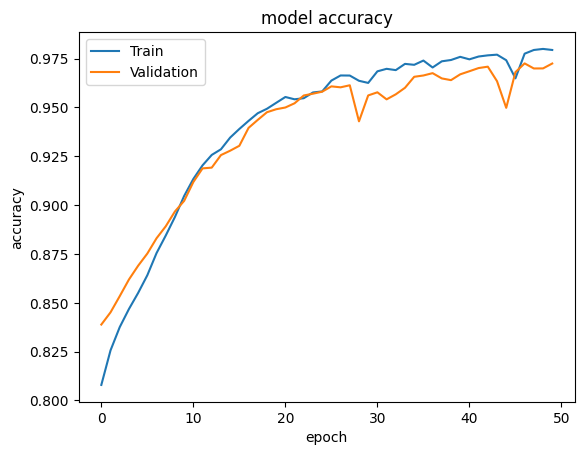

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

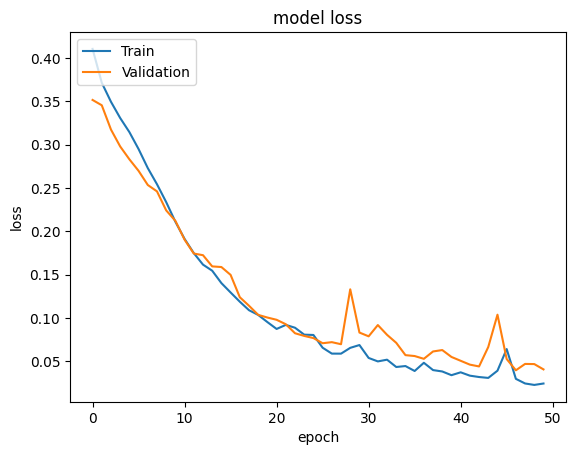

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
true_labels = []
inputs_img = []

for inputs, batch_labels in valid_dataset:
    true_labels.extend(batch_labels.numpy())

predicted_labels = model.predict(valid_dataset)

true_labels = np.array(true_labels).astype(np.uint8)
predicted_labels = np.squeeze(np.array(predicted_labels))

101/101 [==============================] - 1s 6ms/step


In [ ]:
coverage_ratio = CoverageMetric.get_coverage_ratio(true_labels, predicted_labels)
print('Coverage Ratio: ' + str(coverage_ratio))

Coverage Ratio: 0.6842893835616438


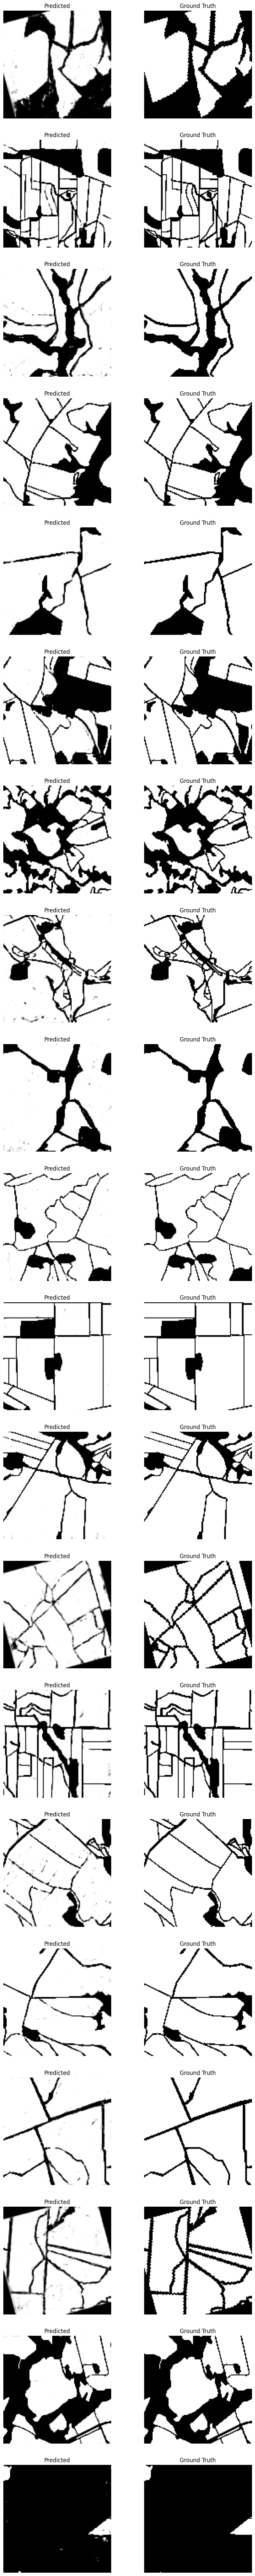

In [ ]:
def plot_images(input, ground_truth, predicted):
    num_images = len(predicted)
    plt.figure(figsize=(10, 5 * num_images))
    for i in range(num_images):
        plt.subplot(num_images, 2, 2*i + 1)
        plt.imshow(predicted[i], cmap='gray')
        plt.title('Predicted')
        plt.axis('off')

        plt.subplot(num_images, 2, 2*i + 2)
        plt.imshow(ground_truth[i] * 255, cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')


plot_images(inputs_img, true_labels, predicted_labels[:20])
plt.show()